![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Lecture 28 - PyTorch</center>
### <center> Regression - Solution</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/28_PyTorch/MainPyTorch1%20-%20Solution.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
#-- Imports:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

#-- torch:
import torch

#-- Fix seed (for presentation sake)
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

### Regression exercise:
* Use the California housing dataset `fetch_california_housing`.
* Use MSE loss (instead of the cross-entropy)
* Replace the classification accuracy with $R^2$ score.
* Try to get the best MSE\R2 score you can.

**Tips**:
* Use `nn.MSELoss`
* You should test different models (layers\activations) and hyper-parameters.
* Try different optimizers and regularizations.
* $R_2 > 0.85$ (on the validation set) is quite good.

In [4]:
from sklearn.datasets import fetch_california_housing

mX, vY  = fetch_california_housing(return_X_y=True)
mX     -= np.mean(mX, axis=0)
mX     /= np.std (mX, axis=0)

mX.shape, vY.shape

((20640, 8), (20640,))

In [5]:
from sklearn.model_selection import train_test_split

Ntrain  = 15000
Ntest   = 5640
vIdx    = np.random.choice(Ntrain + Ntest, Ntrain + Ntest)
mX      = mX[vIdx,:]
vY      = vY[vIdx]

mTrainX, mTestX, vTrainY, vTestY = train_test_split(mX, vY, train_size=Ntrain, test_size=Ntest)

(mTrainX.shape, 
vTrainY.shape, 
mTestX.shape,  
vTestY.shape)

((15000, 8), (15000,), (5640, 8), (5640,))

In [6]:
from torch.utils.data import TensorDataset

oTrainSet = TensorDataset(torch.tensor(mTrainX, dtype=torch.float32), torch.tensor(vTrainY, dtype=torch.float32))
oTestSet  = TensorDataset(torch.tensor(mTestX,  dtype=torch.float32), torch.tensor(vTestY,  dtype=torch.float32))

In [7]:
from sklearn.metrics import r2_score

def R2Score(vY, vHatY):
    return r2_score(vY.detach().cpu(), vHatY.detach().cpu())

In [8]:
def TrainLoop(oModel, oTrainDL, LossFunc, oOptim):

    epochLoss = 0
    epochR2   = 0
    count     = 0                                #-- number of samples
    device    = next(oModel.parameters()).device #-- CPU\GPU
    oModel.train(True)
        
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oTrainDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(device)
        vY = vY.to(device)
        
        #-- Set gradients to zeros:
        oOptim.zero_grad()
        
        #-- Forward:
        vHatY = oModel(mX).squeeze()
        loss  = LossFunc(vHatY, vY)

        #-- Backward:
        loss.backward()

        #-- Parameters update:
        oOptim.step()
        
        print(f'Iteration: {ii:3d}: loss = {loss:.6f}\r', end='')
        #-- Accumulate loss:
        Nb         = mX.shape[0]
        epochLoss += Nb * loss.item()
        epochR2   += Nb * R2Score(vY, vHatY)
        count     += Nb

    epochLoss /= count
    epochR2   /= count
   
    return epochLoss, epochR2

In [9]:
def ValidationLoop(oModel, oValDL, LossFunc):

    if oValDL is None:
        return 0, 0
    
    epochLoss = 0
    epochR2   = 0
    count     = 0                                #-- number of samples
    device    = next(oModel.parameters()).device #-- CPU\GPU
    
    #-- Iterate over the mini-batches:
    oModel.train(False)
    with torch.no_grad():
        for ii, (mX, vY) in enumerate(oValDL):
            #-- Move to device (CPU\GPU):
            mX = mX.to(device)
            vY = vY.to(device)
            
            #-- Forward:
            vHatY = oModel(mX).squeeze()
            loss  = LossFunc(vHatY, vY)

            Nb         = mX.shape[0]
            epochLoss += Nb * loss.item()
            epochR2   += Nb * R2Score(vY, vHatY)
            count     += Nb

    epochLoss /= count
    epochR2   /= count

    return epochLoss, epochR2

In [10]:
import time

def TrainModel(oModel, oTrainDL, oValDL, LossFunc, numEpochs, oOptim):

    bestR2 = 0
    for epoch in range(numEpochs):
        
        startTime          = time.time()
        trainLoss, trainR2 = TrainLoop     (oModel, oTrainDL, LossFunc, oOptim) #-- train
        valLoss,   valR2   = ValidationLoop(oModel, oValDL,   LossFunc)         #-- validation
        
        #-- Display:
        endTime = time.time()
        print('Epoch '              f'{epoch:3d}:',                  end='')
        print(' | Train loss: '     f'{trainLoss:.5f}',              end='')
        print(' | Val loss: '       f'{valLoss:.5f}',                end='')
        print(' | Train R2 score: ' f'{trainR2:2.4f}',               end='')
        print(' | Val R2 score: '   f'{valR2:2.4f}',                 end='')
        print(' | epoch time: '     f'{(endTime-startTime):3.3f} |', end='')
        
        #-- Save best model:
        if valR2 > bestR2:
            bestR2 = valR2
            try:
                torch.save(oModel.state_dict(), 'BestModelParameters.pt')
            except:
                pass
            print(' <-- Checkpoint!')
        else:
            print()

    #-- Return best model:
    oModel.load_state_dict(torch.load('BestModelParameters.pt'))

In [11]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2)

In [12]:
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torchsummary

#-- Model:
def GetModel():
    p      = 0.10
    oModel = nn.Sequential(
        nn.Sequential(), #-- does nothing
        nn.Linear(8,   150), nn.ReLU(), nn.Dropout(p),
        nn.Linear(150, 150), nn.ReLU(), nn.Dropout(p),
        nn.Linear(150, 150), nn.ReLU(), nn.Dropout(p),
        nn.Linear(150, 150), nn.ReLU(), nn.Dropout(p),
        nn.Linear(150, 150), nn.ReLU(), nn.Dropout(p),
        nn.Linear(150, 1),
    )
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchsummary.summary(GetModel(), (8,), device='cpu'); print()

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 8]                   --
├─Linear: 1-2                            [-1, 150]                 1,350
├─ReLU: 1-3                              [-1, 150]                 --
├─Dropout: 1-4                           [-1, 150]                 --
├─Linear: 1-5                            [-1, 150]                 22,650
├─ReLU: 1-6                              [-1, 150]                 --
├─Dropout: 1-7                           [-1, 150]                 --
├─Linear: 1-8                            [-1, 150]                 22,650
├─ReLU: 1-9                              [-1, 150]                 --
├─Dropout: 1-10                          [-1, 150]                 --
├─Linear: 1-11                           [-1, 150]                 22,650
├─ReLU: 1-12                             [-1, 150]                 --
├─Dropout: 1-13                          [-1, 150]                 --


In [13]:
LossFunc = nn.MSELoss()

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

In [15]:
oModel    = GetModel().to(device)
oOptim    = optim.AdamW(oModel.parameters(), lr=4e-4, betas=(0.9, 0.99), weight_decay=2e-5)
numEpochs = 300

TrainModel(oModel, oTrainDL, oTestDL, LossFunc, numEpochs, oOptim)

Epoch   0: | Train loss: 1.72517 | Val loss: 0.74548 | Train R2 score: -0.3056 | Val R2 score: 0.4221 | epoch time: 2.429 | <-- Checkpoint!
Epoch   1: | Train loss: 0.57621 | Val loss: 0.48696 | Train R2 score: 0.5616 | Val R2 score: 0.6238 | epoch time: 2.307 | <-- Checkpoint!
Epoch   2: | Train loss: 0.49974 | Val loss: 0.40264 | Train R2 score: 0.6194 | Val R2 score: 0.6887 | epoch time: 2.161 | <-- Checkpoint!
Epoch   3: | Train loss: 0.47329 | Val loss: 0.38596 | Train R2 score: 0.6403 | Val R2 score: 0.7015 | epoch time: 2.310 | <-- Checkpoint!
Epoch   4: | Train loss: 0.45334 | Val loss: 0.39972 | Train R2 score: 0.6570 | Val R2 score: 0.6913 | epoch time: 2.196 |
Epoch   5: | Train loss: 0.43737 | Val loss: 0.36593 | Train R2 score: 0.6660 | Val R2 score: 0.7170 | epoch time: 2.181 | <-- Checkpoint!
Epoch   6: | Train loss: 0.41983 | Val loss: 0.37844 | Train R2 score: 0.6818 | Val R2 score: 0.7078 | epoch time: 2.162 |
Epoch   7: | Train loss: 0.40420 | Val loss: 0.33771 | Tra

Epoch  64: | Train loss: 0.24607 | Val loss: 0.24961 | Train R2 score: 0.8122 | Val R2 score: 0.8066 | epoch time: 2.111 |
Epoch  65: | Train loss: 0.24788 | Val loss: 0.23728 | Train R2 score: 0.8105 | Val R2 score: 0.8164 | epoch time: 2.182 | <-- Checkpoint!
Epoch  66: | Train loss: 0.24345 | Val loss: 0.24086 | Train R2 score: 0.8144 | Val R2 score: 0.8135 | epoch time: 2.071 |
Epoch  67: | Train loss: 0.24586 | Val loss: 0.24815 | Train R2 score: 0.8127 | Val R2 score: 0.8082 | epoch time: 2.123 |
Epoch  68: | Train loss: 0.24437 | Val loss: 0.25432 | Train R2 score: 0.8132 | Val R2 score: 0.8032 | epoch time: 2.129 |
Epoch  69: | Train loss: 0.23994 | Val loss: 0.22977 | Train R2 score: 0.8169 | Val R2 score: 0.8219 | epoch time: 2.174 | <-- Checkpoint!
Epoch  70: | Train loss: 0.24064 | Val loss: 0.22837 | Train R2 score: 0.8161 | Val R2 score: 0.8233 | epoch time: 2.087 | <-- Checkpoint!
Epoch  71: | Train loss: 0.24421 | Val loss: 0.23541 | Train R2 score: 0.8137 | Val R2 scor

Epoch 195: | Train loss: 0.14953 | Val loss: 0.18191 | Train R2 score: 0.8853 | Val R2 score: 0.8595 | epoch time: 2.165 | <-- Checkpoint!
Epoch 196: | Train loss: 0.15101 | Val loss: 0.18270 | Train R2 score: 0.8847 | Val R2 score: 0.8586 | epoch time: 2.155 |
Epoch 197: | Train loss: 0.14967 | Val loss: 0.18413 | Train R2 score: 0.8847 | Val R2 score: 0.8577 | epoch time: 2.138 |
Epoch 198: | Train loss: 0.15079 | Val loss: 0.18426 | Train R2 score: 0.8844 | Val R2 score: 0.8576 | epoch time: 2.050 |
Epoch 199: | Train loss: 0.14708 | Val loss: 0.18271 | Train R2 score: 0.8874 | Val R2 score: 0.8587 | epoch time: 2.069 |
Epoch 200: | Train loss: 0.14845 | Val loss: 0.18539 | Train R2 score: 0.8864 | Val R2 score: 0.8566 | epoch time: 2.033 |
Epoch 201: | Train loss: 0.14227 | Val loss: 0.18178 | Train R2 score: 0.8910 | Val R2 score: 0.8596 | epoch time: 2.168 | <-- Checkpoint!
Epoch 202: | Train loss: 0.14884 | Val loss: 0.19724 | Train R2 score: 0.8857 | Val R2 score: 0.8474 | epoc

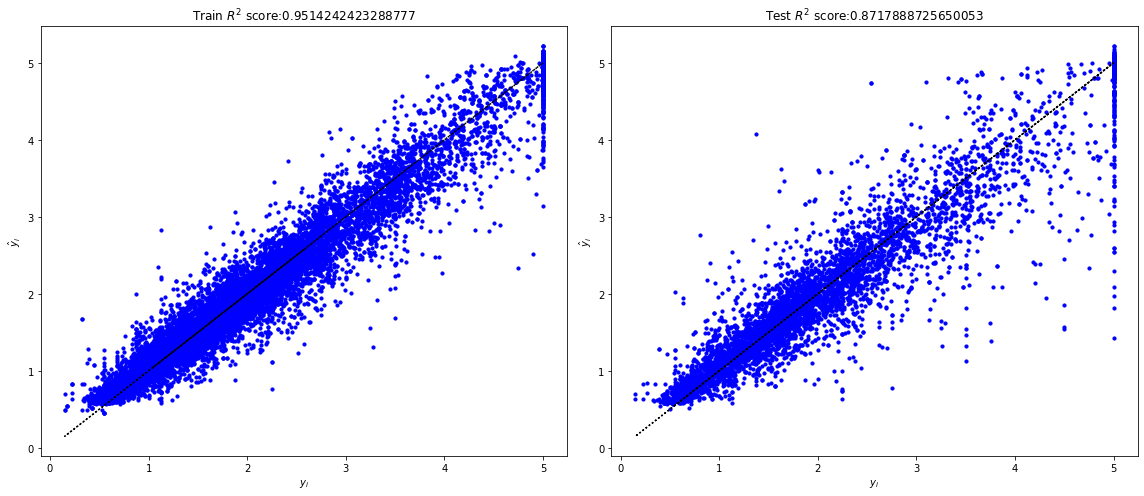

In [17]:
%matplotlib inline

from sklearn.metrics import r2_score

#-- Apply model to data:
vHatTrainY = oModel(torch.tensor(mTrainX, dtype=torch.float32).cuda()).squeeze()
vHatTestY  = oModel(torch.tensor(mTestX,  dtype=torch.float32).cuda()).squeeze()

vHatTrainY = vHatTrainY.squeeze().detach().cpu()
vHatTestY  = vHatTestY. squeeze().detach().cpu()

_, ax = plt.subplots(1, 2, figsize=(16, 7))

ax[0].scatter(vTrainY, vHatTrainY, s=10, c='b', edgecolor=None)
ax[1].scatter(vTestY,  vHatTestY,  s=10, c='b', edgecolor=None)
ax[0].plot(vTrainY,    vTrainY, ':k')
ax[1].plot(vTestY,     vTestY, ':k')
ax[0].set_title('Train $R^2$ score:' f'{r2_score(vTrainY, vHatTrainY)}')
ax[1].set_title('Test $R^2$ score:'  f'{r2_score(vTestY,  vHatTestY)}')
ax[0].set_xlabel('$y_i$')
ax[1].set_xlabel('$y_i$')
ax[0].set_ylabel('$\hat{y}_i$')
ax[1].set_ylabel('$\hat{y}_i$')
plt.tight_layout()
plt.show()